# Survey design assignment

Created by Jacob Deppen, 2021

## Background

A new terminal for the region’s main international airport is set to be built adjacent to the existing airport. When the original airport was constructed in the early 1950s, a survey project identified clusters of Iron Age artifacts that are believed to represent individual households in a loosely-defined village, a rare and important discovery in the region. In preparation for the new terminal, the local government, who operates the airport, has asked your team to survey the planned development site. The main priority identified by local officials is to understand if the Iron Age village extends into the development site and if so, to locate additional Iron Age artifact clusters (households).


## Goal

Submit a survey design that will correctly detect the number of clusters at least 90% of the time. The best design will be the survey that can complete the task in the least amount of total survey time.


## Assumptions

- Surveyors can scan transects at an average rate of about one meter per four seconds.
- Surveyors can scan with a maximum sweep width of two meters.
- Surveyors can scan radial survey units at a rate of about one square meter per ten seconds.
- Recording an artifact takes about 60 seconds.
- The ground has been cleared of vegetation and the surface visibility is perfect throughout the area.
- Iron Age artifacts are easy to recognize.
- You will have an expertly-skilled survey crew who will recognize all Iron Age artifacts and can record artifacts in the minimum time.
- The survey is only expected to identify Iron Age artifacts. No other artifacts were discovered during the 1950s survey.


## Additional details

You are given: 
- Boundary shapefiles for the new terminal development site and the area surveyed in the 1950s. You also have access to the point locations of Iron Age artifacts from the previous survey. 
- Code to generate the `Area`, `Assemblage`, and `Team` building blocks for the 1950s survey. 
- Code to generate the `Area` and `Team` building blocks for the upcoming survey.
- Code to calculate the number of clusters with the DBSCAN algorithm.

You can use these shapefiles and code to try to calibrate your survey design.

## Submission

Your submission should include:
- Python code that will generate a Prospect `Coverage` object for the planned development site. Your Coverage will be run against a range of Assemblage possibilities in the development site to see if it detects the correct number of clusters at least 90% of the time.
- A Jupyter Notebook that demonstrates and explains why you’ve chosen this survey design. In other words, show your work.

In [1]:
from typing import Dict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import prospect
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_style("white")
sns.set_context("notebook")

## Calculate the number of clusters in a GeoDataFrame of points

This same function will be used to evaluate your submission, so you should be careful to avoid altering it, especially the parameters of `DBSCAN`.

In [3]:
def get_n_clusters(points: gpd.GeoDataFrame) -> Dict[str, int]:
    """Calculate the number of clusters using DBSCAN

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame where each row is a point

    Returns
    -------
    Dict[str, int]
        A dictionary with entries for `"n_clusters"` and `"n_noise"` according to
        the output of DBSCAN
    """
    # Wrangle the GeoDataFrame into the form expected by DBSCAN (n_samples, n_features)
    coords = np.stack([points.geometry.x.values, points.geometry.y.values]).T
    # Scale the coordinates
    scaled_coords = StandardScaler().fit_transform(coords)
    # Initialize and fit DBSCAN
    db = DBSCAN(eps=0.3, min_samples=4)
    db.fit(scaled_coords)
    # Grab the cluster labels
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    return {"n_clusters": n_clusters, "n_noise": n_noise}

## Generate Prospect `Area`, `Assemblage`, and `Team` from the 1950 survey

In [4]:
area_1950 = prospect.Area.from_shapefile(
    name="boundary_1950", 
    path="./previous_survey_1950/boundary_1950.shp",
    vis=1.0,
)

layer_1950 = prospect.Layer.from_shapefile(
    path="./previous_survey_1950/artifacts_1950.shp", 
    name="layer_1950", 
    area=area_1950, 
    time_penalty=60, 
    ideal_obs_rate=1.0,
)

assemblage_1950 = prospect.Assemblage(
    name="assemblage_1950", 
    layer_list=[layer_1950],
)

surveyor_1950 = prospect.Surveyor(
    name="surveyor_1950", 
    team_name="team_1950", 
    surveyor_type="expert", 
    skill=1.0, 
    speed_penalty=0.0,
)

team_1950 = prospect.Team(
    name="team_1950", 
    surveyor_list=[surveyor_1950], 
    assignment="naive",
)

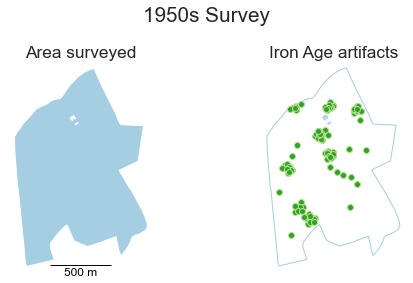

In [11]:
AREA_LT_BLUE = "#a6cee3"
LAYER_GREEN = {"facecolor": "#33a02c", "edgecolor": "#b2df8a"}

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

fig.suptitle("1950s Survey", size="xx-large")

# Area
ax[0].set_title("Area surveyed", size="x-large", pad=0)
area_1950.df.plot(ax=ax[0], color=AREA_LT_BLUE)

# Assemblage
ax[1].set_title("Iron Age artifacts", size="x-large", pad=0)
area_1950.df.plot(ax=ax[1], facecolor="none", edgecolor=AREA_LT_BLUE)
assemblage_1950.df.plot(ax=ax[1], facecolor=LAYER_GREEN["facecolor"], edgecolor=LAYER_GREEN["edgecolor"])

scalebar = AnchoredSizeBar(
    ax[0].transData,
    500, 
    "500 m", 
    "lower center", 
    pad=-0.2,
    color="black",
    frameon=False,
    size_vertical=1)
ax[0].add_artist(scalebar)

for sub_ax in fig.axes:
    sub_ax.axis("off")
sns.despine(left=True, bottom=True)
plt.tight_layout()

## Measuring clusters for 1950s survey

In [8]:
get_n_clusters(assemblage_1950.df)

{'n_clusters': 7, 'n_noise': 10}

## Design and calibrate your survey

Use the above objects to experiment with different `Coverage` configurations and find one that will accurately return the number of clusters in `Assemblage` while minimizing the total survey time.

## Generate Prospect `Area` and `Team` for the proposed survey

After you have a good sense of what approach works well for the 1950 survey area, try to use the same methodology for some hypothetical `Assemblage`s in the `Area` of proposed survey. 

In [6]:
area_proposed = prospect.Area.from_shapefile(
    name="boundary_proposed", 
    path="./proposed_survey/boundary_proposed.shp",
    vis=1.0,
)

surveyor_proposed = prospect.Surveyor(
    name="surveyor_proposed", 
    team_name="team_proposed", 
    surveyor_type="expert", 
    skill=1.0, 
    speed_penalty=0.0,
)

team_proposed = prospect.Team(
    name="team_proposed", 
    surveyor_list=[surveyor_proposed], 
    assignment="naive",
)

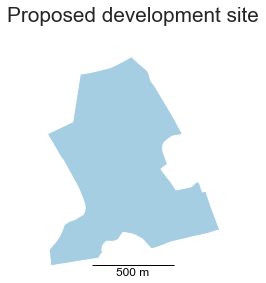

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

fig.suptitle("Proposed development site", size="xx-large")

# Area
# ax[0].set_title("Area to besurveyed", size="x-large", pad=0)
area_proposed.df.plot(ax=ax, color=AREA_LT_BLUE)

scalebar = AnchoredSizeBar(
    ax.transData,
    500, 
    "500 m", 
    "lower center", 
    pad=-0.2,
    color="black",
    frameon=False,
    size_vertical=1)
ax.add_artist(scalebar)

ax.axis("off")
sns.despine(left=True, bottom=True)
plt.tight_layout()